<a href="https://colab.research.google.com/github/HammadB/ProceduralLayout/blob/master/Layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyaml

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from copy import copy
import json as json
import yaml

In [0]:
class Constraint(object):
  
  def evaluate_cost(self):
    return 0

class AreaConstraint(Constraint):
  
  def __init__(self, layoutObjects):
    self._myLayoutObjects = layoutObjects
    
  def evaluate_cost(self):
    sumOfAreas = 0
    for i in range(len(self._myLayoutObjects)):
      for j in range(i + 1, len(self._myLayoutObjects)):
        sumOfAreas += self._myLayoutObjects[i].getIntersection(self._myLayoutObjects[j])
    return sumOfAreas

#Special constraint for plane checking
class BoundaryConstraint(Constraint):
  
  def __init__(self, layoutObjects):
    self._myLayoutObjects = layoutObjects
    
  def evaluate_cost(self):
    for layoutObject in self._myLayoutObjects:
      bbox = layoutObject.getPlane()
      if not(layoutObject.bR.x < bbox.bR.x and layoutObject.bL.x > bbox.bL.x and layoutObject.uR.y < bbox.uR.y and layoutObject.bR.y > bbox.bR.y):
        return float("inf")
    return 0

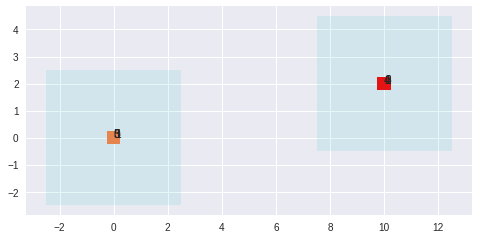

In [4]:
#Boilerplate code for 
class Vector2(object):
  x = None
  y = None
  
  def __init__(self, x, y):
    self.x = x
    self.y = y 
  
class LayoutObject(object):
  empty = 0
  _myPlane = None
        
  def getIntersection(self, otherLayoutObject):
    return None #not implemented
  
  def setPlane(self, plane):
    self._myPlane = plane
    
  def getPlane(self):
    return self._myPlane
 
  def __copy__(self):
    print("ERROR NOT IMPLEMENTED")
  
class Box(LayoutObject):
  center = None
  size = None
  uL = None
  uR = None
  bL = None
  bR = None

  #Center is a Vector2
  def __init__(self, center, size):
    self.center = center
    self.size = size
    self.uL = Vector2(center.x - size/2., center.y + size/2)
    self.uR = Vector2(center.x + size/2., center.y + size/2) 
    self.bL = Vector2(center.x - size/2., center.y - size/2)    
    self.bR = Vector2(center.x + size/2., center.y - size/2) 
    
    
  def updateCoordinates(self, center):
    self.center = center
    self.uL = Vector2(center.x - self.size/2., center.y + self.size/2)
    self.uR = Vector2(center.x + self.size/2., center.y + self.size/2) 
    self.bL = Vector2(center.x - self.size/2., center.y - self.size/2)    
    self.bR = Vector2(center.x + self.size/2., center.y - self.size/2) 
     
  
  def __copy__(self):
    return Box(self.center, self.size)
  
  #Only supports intersections with other boxes
  def getIntersection(self, otherLayoutObject):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(self.uL.x, otherLayoutObject.uL.x)
    yA = min(self.uL.y, otherLayoutObject.uL.y) #A : upper left
    xB = min(self.bR.x, otherLayoutObject.bR.x)
    yB = max(self.bR.y, otherLayoutObject.bR.y) #B: bottom right
    return max(0, xB - xA) * max(0, yA - yB)
  
    
class Layout(object):
  
  def __init__(self, layoutObjects, planeBoxes, doAssignment=False):
    self._myLayoutObjects = layoutObjects
    self.planeBoxes = planeBoxes
    self._myConstraints = []
    self._myConstraints.append(BoundaryConstraint(self._myLayoutObjects))
    self.addConstraint(AreaConstraint(self.getLayoutObjects()))
    if doAssignment:
      self._assignBoxes()
    
  def _assignBoxes(self):
    for layoutObj in self._myLayoutObjects:
      objArea = layoutObj.size ** 2
      indexes = np.arange(len(self.getPlaneBoxes()))
      np.random.shuffle(indexes)
      for j in indexes:
        candidatePlane = self.planeBoxes[j]
        if objArea < candidatePlane.size**2:
          layoutObj.setPlane(candidatePlane)
          layoutObj.updateCoordinates(candidatePlane.center)
          break
      
  def getLayoutObjects(self):
    return self._myLayoutObjects
  
  def getPlaneBoxes(self):
    return self.planeBoxes
  
  def addConstraint(self, constraint):
    self._myConstraints.append(constraint)
  
  def getConstraints(self):
    return self._myConstraints
  
  def drawLayout(self):
    plt.axes()
    x = np.arange(len(self._myLayoutObjects))
    ys = [i+x+(i*x)**2 for i in range(len(self._myLayoutObjects))]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    #For now all layout objects are Boxes
    i = 0
    for box in self._myLayoutObjects:
      shape = plt.Rectangle((box.bL.x, box.bL.y), box.size, box.size, fc=colors[i])
      plt.gca().add_patch(shape)
      #label the box
      plt.text(box.center.x, box.center.y, str(i))
      i += 1
    #bounding box
    for planeBox in self.getPlaneBoxes():
      shape = plt.Rectangle((planeBox.bL.x, planeBox.bL.y), planeBox.size, planeBox.size, fc="c", alpha=0.1)
      plt.gca().add_patch(shape)
    plt.axis('scaled')
    plt.show()
   
  def __copy__(self):
    newLayoutObjects = []
    for layoutObject in self.getLayoutObjects():
      newLayoutObject = copy(layoutObject)
      newLayoutObjects.append(newLayoutObject)
    return Layout(*newLayoutObjects) 
  
  
b = Box(Vector2(0, 0), 0.2)
b2 = Box(Vector2(0, 0),  0.5)
b3 = Box(Vector2(0, 0),  0.5)
b4 = Box(Vector2(0, 0),  0.5)
b5 = Box(Vector2(0, 0),  0.5)
b6 = Box(Vector2(0, 0),  0.5)
b7 = Box(Vector2(0, 0),  0.5)
b7 = Box(Vector2(0, 0),  0.5)
boxes = [b, b2, b3 ,b4, b5, b6, b7]

bounds = Box(Vector2(0, 0),  5)
bounds2 = Box(Vector2(10, 2), 5)
layout = Layout([b, b2, b3 ,b4, b5, b6, b7], [bounds, bounds2], doAssignment=True)
layout.drawLayout()
    


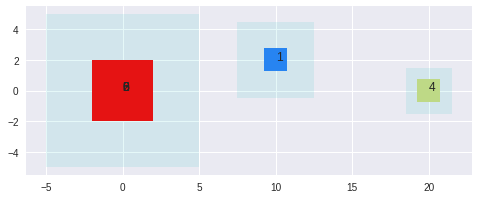

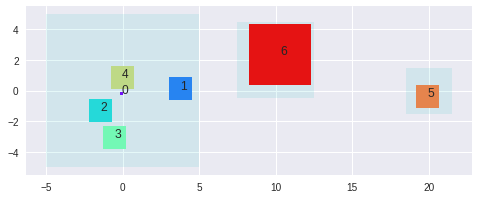

In [5]:
def boltzmann(cost, beta=1.0):
  return np.exp(-beta*cost)

def acceptanceProbability(current_cost, proposed_cost):
  return min(1, boltzmann(proposed_cost)/boltzmann(current_cost))


def get_cost(layout, constraints):
  layoutObjects = layout.getLayoutObjects()
  cost = 0

  for constraint in constraints:
    cost += constraint.evaluate_cost()

  return cost


def propose_new_layout(current_layout, prob_swap_plane=0.05, perturb=0.1):
  new_layout_objects = []
  planeBoxes = current_layout.getPlaneBoxes()
  
  for rect in current_layout.getLayoutObjects():
    rect_center = rect.center 
    new_center = Vector2(rect_center.x + np.random.normal(scale=perturb), rect_center.y + np.random.normal(scale=perturb))
    new_rect = Box(new_center, rect.size)
    new_rect.setPlane(rect.getPlane())
    new_layout_objects.append(new_rect)
  
  
  if np.random.random() < prob_swap_plane: 
    randomObject = new_layout_objects[np.random.randint(len(new_layout_objects))]
    randomPlane = planeBoxes[np.random.randint(len(planeBoxes))]
    randomObject.setPlane(randomPlane) # !! probably just make setPlane also updateCoordinate
    randomObject.updateCoordinates(randomPlane.center)
    
  
  return Layout(new_layout_objects, planeBoxes)


def metropolis_hastings(initial_layout, num_iters=10000):
  cur_cost = get_cost(initial_layout, initial_layout.getConstraints())
  cur_layout = initial_layout
  best_layout = cur_layout
  best_cost = float("inf")
  
  for i in range(num_iters):
    new_layout = propose_new_layout(cur_layout)
    new_cost = get_cost(new_layout, new_layout.getConstraints())
    if np.random.random() < acceptanceProbability(cur_cost, new_cost):
      cur_layout = new_layout
      cur_cost = new_cost
      if cur_cost < best_cost:
        best_layout = cur_layout
        best_cost = cur_cost
      
  return best_layout


b = Box(Vector2(0, 0), 0.2)
b2 = Box(Vector2(0, 0),  1.5)
b3 = Box(Vector2(0, 0),  1.5)
b4 = Box(Vector2(0, 0),  1.5)
b5 = Box(Vector2(0, 0),  1.5)
b6 = Box(Vector2(0, 0),  1.5)
b7 = Box(Vector2(0, 0),  0.5)
b7 = Box(Vector2(0, 0),  4)
boxes = [b, b2, b3 ,b4, b5, b6, b7]

bounds = Box(Vector2(0, 0),  10)
bounds2 = Box(Vector2(10, 2), 5)
bounds3 = Box(Vector2(20, 0), 3)
layout = Layout([b, b2, b3 ,b4, b5, b6, b7], [bounds, bounds2, bounds3], doAssignment=True)
layout.drawLayout()
final_layout = metropolis_hastings(layout, num_iters=10000)
final_layout.drawLayout()

In [6]:
with open('test.yaml', 'r') as layoutdef:
  data = layoutdef.read()
  lol = yaml.load(data)
print(lol)

{'classes': [{'.couch': [{'color': 'black'}, {'semantic-affinity': 'couch'}, {'facing': '.person'}]}, {'.person': [{'scale': 4.2}, {'padding': '0.1, 0.1, 0.1, 0.1, 0.1, 0.1'}, {'distance': [{'.couch': '0.75m - 1m'}]}]}, '.chair']}
